In [7]:

# NOTE: .cdsapirc needs to be set up in your home repo
# Go to https://cds.climate.copernicus.eu/
# Click on profile to get API key

from pathlib import Path
import cdsapi
import torch
import xarray as xr
from aurora import Batch, Metadata, Aurora, rollout
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Proj


# Data will be downloaded here.
download_path = Path("../downloads/")
print(download_path)

../downloads


In [2]:
# Download the static variables.
c = cdsapi.Client()

if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

# Download the surface-level variables.
if not (download_path / "2023-01-01-surface-level.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "mean_sea_level_pressure",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-surface-level.nc"),
    )
print("Surface-level variables downloaded!")

# Download the atmospheric variables.
if not (download_path / "2023-01-01-atmospheric.nc").exists():
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "temperature",
                "u_component_of_wind",
                "v_component_of_wind",
                "specific_humidity",
                "geopotential",
            ],
            "pressure_level": [
                "50",
                "100",
                "150",
                "200",
                "250",
                "300",
                "400",
                "500",
                "600",
                "700",
                "850",
                "925",
                "1000",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": ["00:00", "06:00", "12:00", "18:00"],
            "format": "netcdf",
        },
        str(download_path / "2023-01-01-atmospheric.nc"),
    )
print("Atmospheric variables downloaded!")

2024-11-01 09:12:45,081 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-01 09:12:45,083 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-11-01 09:12:45,083 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-01 09:12:45,084 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-01 09:12:45,084 WARNING [2024-06-16T

Static variables downloaded!
Surface-level variables downloaded!
Atmospheric variables downloaded!


In [3]:
# Prepare batches of data

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / "2023-01-01-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / "2023-01-01-atmospheric.nc", engine="netcdf4")

i = 1  # Select this time index in the downloaded data.

batch = Batch(
    surf_vars={
        # First select time points `i` and `i - 1`. Afterwards, `[None]` inserts a
        # batch dimension of size one.
        "2t": torch.from_numpy(surf_vars_ds["t2m"].values[[i - 1, i]][None]),
        "10u": torch.from_numpy(surf_vars_ds["u10"].values[[i - 1, i]][None]),
        "10v": torch.from_numpy(surf_vars_ds["v10"].values[[i - 1, i]][None]),
        "msl": torch.from_numpy(surf_vars_ds["msl"].values[[i - 1, i]][None]),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": torch.from_numpy(atmos_vars_ds["t"].values[[i - 1, i]][None]),
        "u": torch.from_numpy(atmos_vars_ds["u"].values[[i - 1, i]][None]),
        "v": torch.from_numpy(atmos_vars_ds["v"].values[[i - 1, i]][None]),
        "q": torch.from_numpy(atmos_vars_ds["q"].values[[i - 1, i]][None]),
        "z": torch.from_numpy(atmos_vars_ds["z"].values[[i - 1, i]][None]),
    },
    metadata=Metadata(
        lat=torch.from_numpy(surf_vars_ds.latitude.values),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element.
        time=(surf_vars_ds.valid_time.values.astype("datetime64[s]").tolist()[i],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.pressure_level.values),
    ),
)

In [4]:
# Instantiate model - requires downloading model weights

model = Aurora(use_lora=False)  # The pretrained version does not use LoRA.
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

In [11]:
# Access the projection information
static_vars_ds.attrs

# Get the coordinates
lat = static_vars_ds.coords['latitude']
lon = static_vars_ds.coords['longitude']

# Infer the projection
projection = Proj('+proj=latlong')

# Print the projection information
print(projection)

proj=longlat datum=WGS84 no_defs ellps=WGS84 towgs84=0,0,0


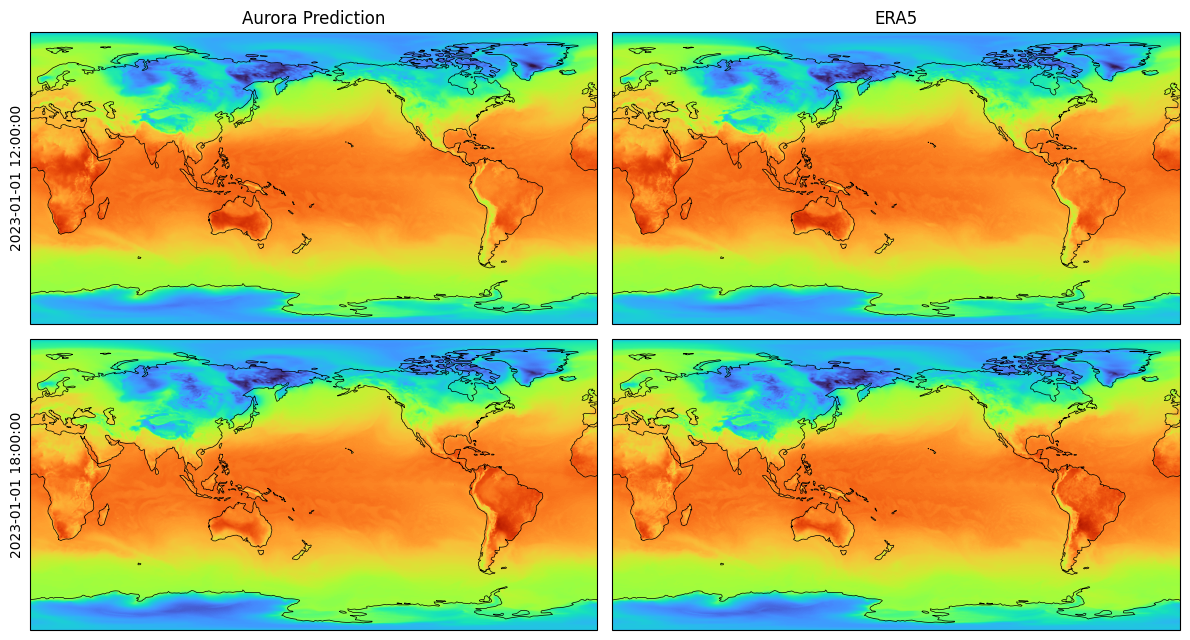

In [24]:
# Plot model outputs
import numpy as np

# fig, ax = plt.subplots(2, 2, figsize=(12, 6.5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

crs = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(2, 2, figsize=(12, 6.5), subplot_kw={'projection': crs})

lon = np.arange(-180, 180, 0.25)
lat = np.arange(-90, 90, 0.25)
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

for i in range(ax.shape[0]):
    pred = preds[i]

    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50, cmap='turbo', transform=crs, extent=extent)
    # Add coastlines with cartopy
    ax[i, 0].coastlines(linewidth=0.5)
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_aspect('auto')

    ax[i, 1].set_global()
    ax[i, 1].imshow(surf_vars_ds["t2m"][2 + i].values - 273.15, vmin=-50, vmax=50, cmap='turbo', transform=crs, extent=extent)
    ax[i, 1].coastlines(linewidth=0.5)
    if i == 0:
        ax[i, 1].set_title("ERA5")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_aspect('auto')



plt.tight_layout()
plt.savefig("outputs.png")
plt.show()